### Import modules

In [1]:
import math
import numpy as np
import tensorflow as tf
from pprint import pprint
from scipy.io import loadmat
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load data

In [2]:
# each sample lasts 30 seconds (sampling rate: 200 Hz)
eeg_data = loadmat("./eeg_data.mat")
x = eeg_data['X_train']

# labels
sleep_stages = eeg_data['y_train']
sleep_stages[sleep_stages == 'W '] = 'W'
sleep_stages[sleep_stages == 'R '] = 'R'
print(np.unique(sleep_stages))

# targets
le = LabelEncoder()
labels = le.fit_transform(sleep_stages)
y = to_categorical(labels)

['N1' 'N2' 'N3' 'R' 'W']


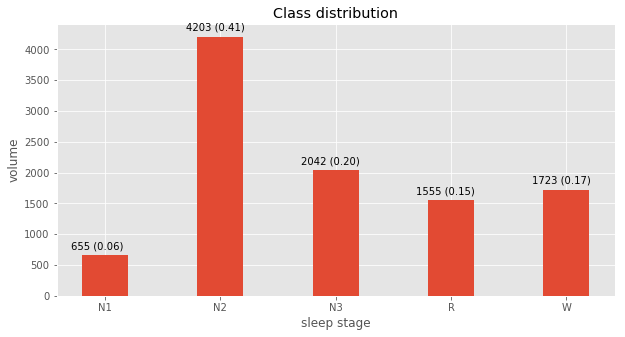

In [3]:
hx, hy = np.transpose(tuple(Counter(labels).items()))

# figure
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.set(title="Class distribution")
ax.bar(hx, hy, width=0.4)
ax.set_xticklabels([""] + [le.inverse_transform(x) for x in range(5)])
ax.set_xlabel("sleep stage")
ax.set_ylabel("volume")
total = np.sum(hy)
for i, j in zip(hx, hy):
    ax.text(i - 0.3, j + 100, "%d (%.2f)" % (j, j/total))
plt.show()

In [4]:
# shape
print(x.shape)

(10178, 6000)


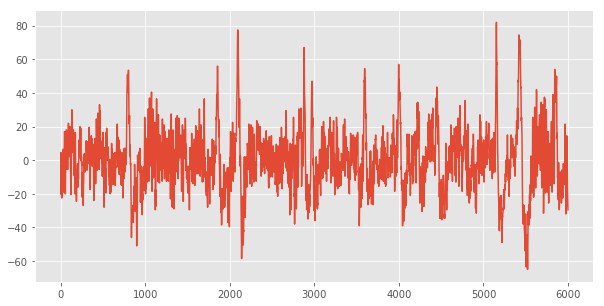

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(x[0])

## Sub-sampling eeg signal

In [71]:
# sub-sampling
x_sub = x[:, ::6]
print(x_sub.shape)

(10178, 1000)


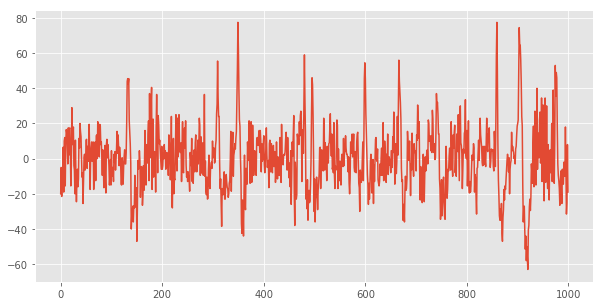

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(x_sub[0])

## CNN architecture

In [73]:
# parameters
win_sec = 3
overlap = 1
num_filters = 100
learning_rate = 1e-2

# pretty print
n, sample_size = x_sub.shape
freq = sample_size / 30
num_classes = np.shape(y)[1]

# first pooling
win_size = int(win_sec * freq)
overlap_size = int(overlap * freq)
filter_size = win_size
stride = overlap_size
print("%d samples" % n)
print("sampling rate: %.2f Hz" % freq)
print("sample size: %d" % sample_size)
print()
print("window of %.2f seconds: filter size of %d samples" % (win_sec, win_size))
print("overlapping windows of %.2f seconds: stride of %d samples" % (overlap, overlap_size))
print()
print("number of classes: %d" % num_classes)
print("number of filter size: %d" % num_filters)

10178 samples
sampling rate: 33.33 Hz
sample size: 1000

window of 3.00 seconds: filter size of 100 samples
overlapping windows of 1.00 seconds: stride of 33 samples

number of classes: 5
number of filter size: 100


In [74]:
# helper functions 
def apply_conv(x, filter_size, stride, num_filters):
    filter_shape = [filter_size, 1, 1, num_filters]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    conv = tf.nn.conv2d(x,
                        W, 
                        strides=[1, stride, 1, 1],
                        padding='VALID',
                        name='conv')
    b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
    return tf.nn.bias_add(conv, b)

def apply_max_pool(h, num_filters):
    shape_ = h.get_shape().as_list()
    h_pool = tf.nn.max_pool(h,
                            ksize=[1, shape_[1], 1, 1],
                            strides=[1, 1, 1, 1], 
                            padding='VALID',
                            name='pool')
    return h_pool

In [75]:
%%time

# placeholders
x_input = tf.placeholder(tf.float32, shape=[None, sample_size], name='x_input')
y_input = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")

with tf.device("/cpu:0"):
    
    # resize time series
    with tf.name_scope("expand"):
        x_expanded = tf.expand_dims(tf.expand_dims(x_input, -1), -1)
    
    with tf.name_scope("convolution"):
        conv = apply_conv(x_expanded, filter_size, stride, num_filters)
        h = tf.nn.relu(conv, name='relu')
        h_pool = apply_max_pool(h, num_filters)
        h_flat = tf.reshape(h_pool, [-1, num_filters])
        
    # dropout
    with tf.name_scope("dropout"):
        h_o = tf.nn.dropout(h_flat, dropout)

    # output
    with tf.name_scope("output"):
        W_o = tf.Variable(
            tf.truncated_normal(
                [num_filters, num_classes], stddev=0.1 ), 
                name='W_o'
        )
        b_o = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b_o')
        preds = tf.nn.xw_plus_b(h_o, W_o, b_o, name='preds')
        
    # cross-entropy loss
    with tf.name_scope("loss"):
        losses = tf.nn.softmax_cross_entropy_with_logits(
            logits=preds,
            labels=y_input,
            name='losses'
        )
        loss = tf.reduce_mean(losses, name='loss')

    # optimization
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss) 
        
    # accuracy
    with tf.name_scope("accuracy"):
        labels_pred = tf.argmax(preds, axis=1) 
        labels_true = tf.argmax(y_input, axis=1)
        correct_predictions = tf.equal(labels_pred, labels_true)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
        
    init = tf.global_variables_initializer()

CPU times: user 561 ms, sys: 23.6 ms, total: 584 ms
Wall time: 948 ms


In [76]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub, y_input: y, dropout: 1}
    test_out = sess.run(preds, feed_dict=D)
    
print(test_out[0])

[-51.93195724  -7.99530935  21.75345612   0.93869841  24.2766571 ]
CPU times: user 2.55 s, sys: 347 ms, total: 2.89 s
Wall time: 2.11 s


In [77]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub, y_input: y, dropout: 1}
    acc, lb_pred, lb_true = sess.run([accuracy, labels_pred, labels_true], feed_dict=D)
    
print(acc)
print(Counter(lb_pred))
print(Counter(lb_true))

0.12753
Counter({0: 5068, 4: 4560, 2: 299, 1: 250, 3: 1})
Counter({1: 4203, 2: 2042, 4: 1723, 3: 1555, 0: 655})
CPU times: user 2.74 s, sys: 216 ms, total: 2.96 s
Wall time: 2.1 s


In [78]:
batch_size = 32
num_epochs = 3 
p = 1
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x_sub, y, train_size=0.75, random_state=seed)

In [79]:
%%time

np.random.seed(10)
with tf.Session() as sess:
    # init
    sess.run(init)
    acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: 1})
    acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
    print("init.: _ train acc: %0.2f test acc: %0.2f" % (acc_train, acc_test))
    
    # training
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_ys = y_train[idx: idxn]
            feed_train = {x_input: batch_xs, y_input: batch_ys, dropout: p}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)
            
        acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: p})
        acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
        print("epoch: %d train acc: %0.2f test acc: %0.2f" % (e, acc_train, acc_test))
        
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)
    
    # use trained model
    feed = {x_input: x_test, y_input: y_test, dropout: 1}
    lb_pred, lb_true = sess.run([labels_pred, labels_true], feed_dict=feed)
    
    # debug
    test_out = sess.run(preds, feed_dict=feed)

init.: _ train acc: 0.20 test acc: 0.20
epoch: 0 train acc: 0.43 test acc: 0.40
epoch: 1 train acc: 0.55 test acc: 0.52
epoch: 2 train acc: 0.57 test acc: 0.54
CPU times: user 23.7 s, sys: 2.21 s, total: 25.9 s
Wall time: 16.1 s


Counter({2: 990, 1: 903, 4: 488, 3: 160, 0: 4})
Counter({1: 1081, 2: 505, 4: 438, 3: 377, 0: 144})


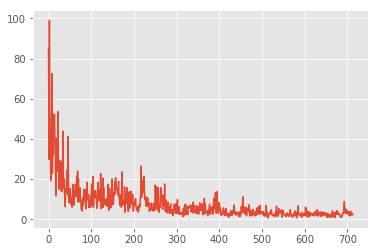

In [80]:
plt.plot(losses)
print(Counter(lb_pred))
print(Counter(lb_true))